In [1]:
import glob
import os
import pprint
import traceback
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [2]:
 def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        'compressedHistograms': 1,
        'images': 1,
        'scalars': 0,  # 0 means load all
        'histograms': 1,
    }
    runlog_data = pd.DataFrame({'metric': [], 'value': [], 'step': []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()['scalars']
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {'metric': [tag] * len(step), 'value': values, 'step': step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print('Event file possibly corrupt: {}'.format(path))
        traceback.print_exc()
    return runlog_data

In [3]:
experiments = []
for cost in ['reward', 'critic-train']:
    for alpha in ['05', '1']:
        if cost=='reward':
            name = 'Reward Based'
        else:
            name = 'Safety Training'
        if alpha=='05':
            name += ' alpha=0.5'
        else:
            name += ' alpha=1.0'
        experiments.append((name, f'drq_{cost}_alpha-{alpha}'))

In [5]:
frames = []
base_path = '../../../output/final/fetch-push-barrier-drq-final/'
for name, path in experiments:
    tb = glob.glob(os.path.join(base_path, f'{path}/tb/*'))[0]
    df = tflog2pandas(tb)
    df['algo'] = name
    frames.append(df)

In [6]:
logs = pd.DataFrame()
for frame in frames:
    logs = logs.append(frame, ignore_index=True)

In [7]:
logs = logs.sort_values(by=['algo'])

In [8]:
logs

,metric,value,step,algo
0,train/episode,1.000000,0.0,Reward Based alpha=1.0
502462,train_actor/target_entropy,-4.000000,1799000.0,Reward Based alpha=1.0
502463,train_actor/target_entropy,-4.000000,1799025.0,Reward Based alpha=1.0
502464,train_actor/target_entropy,-4.000000,1799050.0,Reward Based alpha=1.0
502465,train_actor/target_entropy,-4.000000,1799075.0,Reward Based alpha=1.0
...,...,...,...,...
251237,train/batch_reward,-0.063009,1590375.0,Reward Based alpha=1.0
251238,train/batch_reward,-0.063513,1590400.0,Reward Based alpha=1.0
251239,train/batch_reward,-0.063051,1590425.0,Reward Based alpha=1.0
251230,train/batch_reward,-0.068944,1590200.0,Reward Based alpha=1.0


In [21]:
logs.to_pickle('results/push-barrier-drq-final/graph_data.pkl')

In [10]:
logs = pd.read_pickle('results/push-barrier-drq-final/graph_data.pkl')

In [12]:
def plot(data, metric, name, y_low, y_high, image_name=None, color_palette="colorblind", dashes=None, legend=True, legend_offset=-0.11, size=(20,10)):
    fig = plt.figure(figsize=size)
    fig.patch.set_facecolor('white')
    plt.ticklabel_format(scilimits=[-5,3])
    

    # set style and context
    sns.set_context("notebook")
    sns.set(style='whitegrid', font_scale=2)

    # create graph
    graph = sns.lineplot(data=data[data['metric']==metric], 
                        x='step', 
                        y='value', 
                        hue='algo',
                        style='algo',
                        ci='sd',
                        palette=color_palette,
                        dashes=dashes)

    # set legend options
    handles, labels = graph.get_legend_handles_labels()
    if legend:
        fig.legend(loc='lower center', 
                   bbox_to_anchor=(0.5, legend_offset), 
                   fancybox=True, 
                   shadow=True, 
                   ncol=5, 
                   prop={'size': 19})

    # graph options
    graph.legend([],[], frameon=False)
    graph.set(xlabel='Environment Steps', ylabel=name)
    #graph.title.set_text('FetchReach')
    #graph.title.set_size(26)
    graph.set_ylim(y_low, y_high)
    graph.set_xlim(0, 2000000)
    #fig.tight_layout(pad=2.0)
    if image_name != None:
        plt.savefig(image_name, bbox_inches='tight')#, pad_inches=0.1)

In [13]:
dashes = {algo: () if i <= 9 else (6,4) for i, algo in enumerate(logs['algo'].unique())}

In [14]:
colors = {algo: sns.color_palette('colorblind', logs['algo'].nunique())[i] for i, algo in enumerate(logs['algo'].unique())}

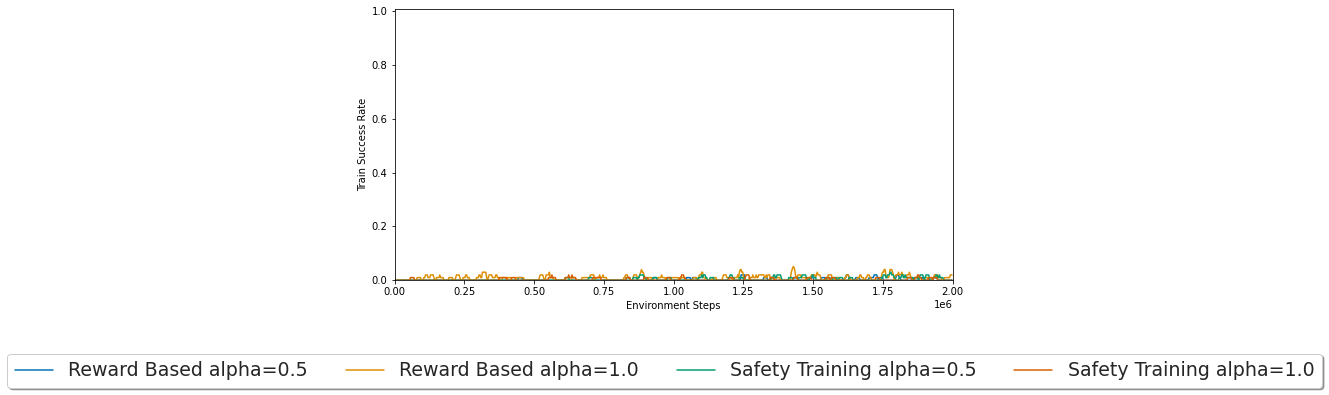

In [15]:
plot(logs[logs['step']%1000==0], 'train/success_rate', 'Train Success Rate', 0, 1.01, 'results/push-barrier-drq-final/success.png', colors, dashes, legend_offset=-0.2, size=(10,5))

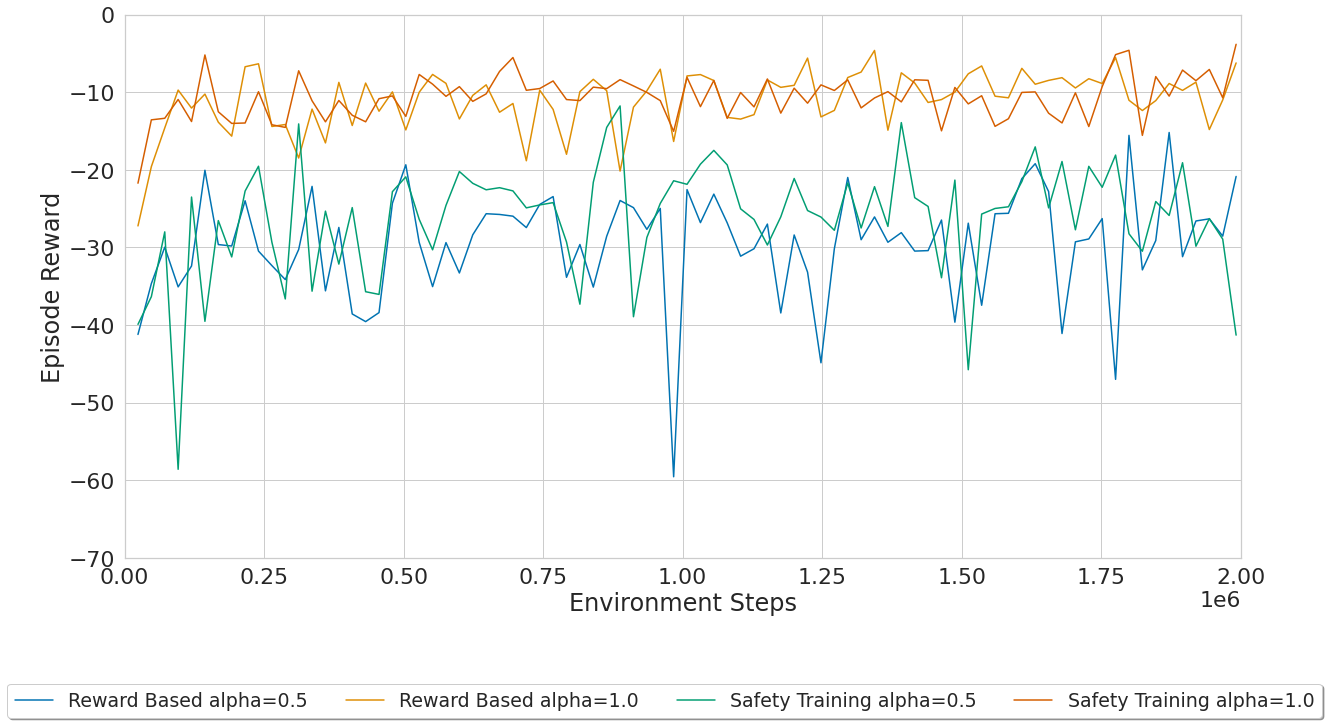

In [16]:
plot(logs[logs['step'] % 8000 == 0], 'train/episode_reward', 'Episode Reward', -70, 0, 'results/push-barrier-drq-final/reward.png', colors, dashes)

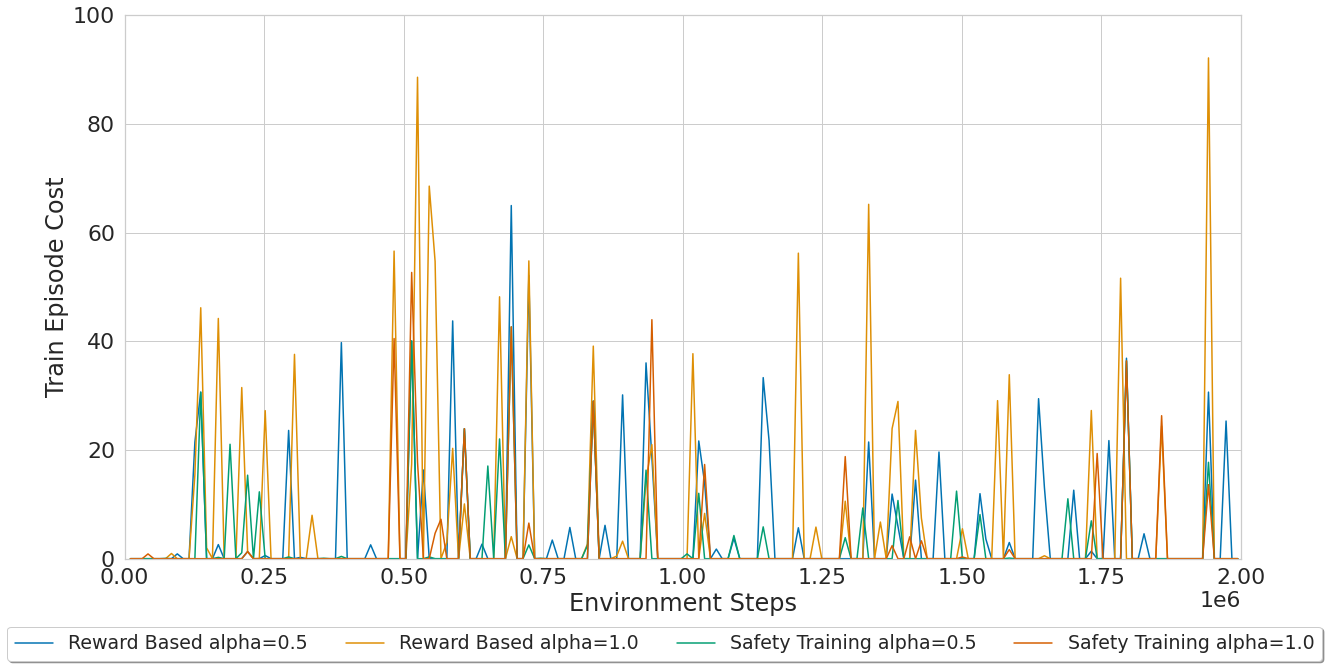

In [18]:
plot(logs[logs['step'] % 3500 == 0], 'train/episode_cost', 'Train Episode Cost', 0, 100, 'results/push-barrier-drq-final/cost.png', colors, dashes, legend_offset=-0.03, size=(20,10))

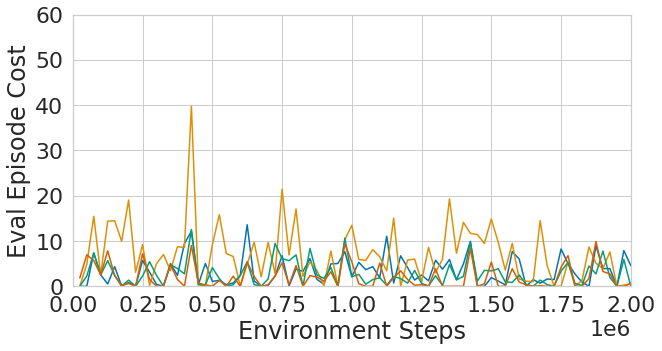

In [19]:
plot(logs, 'eval/episode_cost', 'Eval Episode Cost', 0, 60, 'results/push-barrier-drq-final/eval_cost.png', colors, dashes, legend=False, size=(10,5))

In [5]:
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb

In [7]:
rgb_to_hex(tuple([int(255*x) for x in colors['Safety Training']]))

'de8f05'